In [ ]:
import cv2
import numpy as np
from math import cos, pi, sqrt, ceil
from collections import Counter
from math import ceil
from collections import Counter
from math import sqrt, cos
import matplotlib.pyplot as plt

quant_lum = [
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 48, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
]

quant_chr = [
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
]

**Color space conversion (e.g., RGB to YCbCr)**

In [ ]:
def rgb_to_ycbcr(input):
    rows, cols, _ = input.shape
    result = np.zeros((rows, cols, 3), dtype=np.float32)

    for r in range(rows):
        for c in range(cols):
            R,G,B = input[r, c]
            result[r, c, 0] = 0.299 * R + 0.587 * G+ 0.114 *B          # Y
            result[r, c, 1] = -0.1687 * R - 0.3313 *G + 0.5 * B+ 128   # Cb
            result[r, c, 2] = 0.5 * R - 0.4187 *G - 0.0813 *B + 128    # Cr
    # Display the original and YCbCr images
    plt.figure(figsize=(10, 5))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(input.astype(np.uint8))
    plt.title("Original RGB Image")
    plt.axis('off')

    # Display the YCbCr image
    plt.subplot(1, 2, 2)
    plt.imshow(result.astype(np.uint8))
    plt.title("Converted YCbCr Image")
    plt.axis('off')

    plt.show()

    return result

**Sub-sampling**

In [ ]:
def subsample(input):
    result = [[0]*len(input[0])]*len(input)

    # 4:2:0 subsampling
    # The loop iterates over every 2x2 block, calculates the average value, and assigns it to the corresponding position in ans
    for r in range(int(len(input)/2)):
        for c in range(int(len(input[0])/2)):

            result[2*r][2*c] = (input[2*r][2*c]+input[2*r+1][2*c] + input[2*r][2*c+1] + input[2*r+1][2*c+1])/4
            result[2*r][2*c+1] = result[2*r+1][2*c] = result[2*r+1][2*c+1] = result[2*r][2*c]

    return result[::2]


**Discrete Cosine Transform (DCT)**

In [ ]:
def dct(matrix):

    matrix = np.array(matrix)
    N = matrix.shape[0]
    dct_matrix = np.zeros((N, N))

    for r in range(N):
        for c in range(N):
            # Calculate alpha(u) and alpha(v)
            ralpha = np.sqrt(1 / N) if r == 0 else np.sqrt(2 / N)
            calpha = np.sqrt(1 / N) if c == 0 else np.sqrt(2 / N)

            # Sum over the input matrix elements
            sum_val = 0.0
            for i in range(N):
                for j in range(N):
                    sum_val += matrix[i, j] * np.cos((2 * i + 1) * r * np.pi / (2 * N)) * np.cos((2 * j + 1) * c * np.pi / (2 * N))

            # Compute the DCT coefficient
            dct_matrix[r, c] = ralpha * calpha * sum_val

    return dct_matrix

In [ ]:
def Centralize(input):
    for i in range(len(input)):
      for j in range(len(input[0])):
        input[i][j] -= 128
    return input

In [ ]:
def get_freq_dict(input):
    data = Counter(input)
    result = {k: d / len(input) for k, d in data.items()}
    return result

def get_lowprob(prob):
    sorted_prob = sorted(prob.items(), key=lambda x: x[1])
    return sorted_prob[0][0], sorted_prob[1][0]


In [ ]:
def serialize(input):
    hor = 0
    vert = 0
    i = 0
    result = [0]*64

    while (vert < 8) and (hor < 8):
        if ((hor + vert) % 2) == 0:
            if vert == 0:
                result[i] = input[vert][hor]
                if hor == 8:
                    vert += 1
                else:
                    hor += 1
                i += 1
            elif (hor == 7) and (vert < 8):
                result[i] = input[vert][hor]
                vert += 1
                i += 1
            elif (vert > 0) and (hor < 7):
                result[i] = input[vert][hor]
                vert -= 1
                hor += 1
                i += 1
        else:
            if (vert == 7) and (hor <= 7):
                result[i] = input[vert][hor]
                hor += 1
                i += 1
            elif hor == 0:
                result[i] = input[vert][hor]
                if vert == 7:
                    hor += 1
                else:
                    vert += 1
                i += 1
            elif (vert < 7) and (hor > 0):
                result[i] = input[vert][hor]
                vert += 1
                hor -= 1
                i += 1
        if (vert == 7) and (hor == 7):
            result[i] = input[vert][hor]
            break
    return result

**Run Length and huffman Encoding**

In [ ]:
def trim(input):
    trimmed = input.copy()
    while(len(trimmed) > 0 and trimmed[-1] == 0):
      trimmed.pop(-1)
    if len(trimmed) == 0:
        trimmed = [0]
    return trimmed


In [ ]:
def run_length(input):
    result = []
    cnt = 0
    eob = ("EOB",)

    for i in range(len(input)):
        trimmed = trim(input[i])
        for j in range(len(trimmed)):
            if i == 0 and j == 0:
                result.append((int(trimmed[j]).bit_length(), trimmed[j]))
            elif j == 0:
                diff = int(input[i][j] - input[i - 1][j])
                if diff != 0:
                    result.append((diff.bit_length(), diff))
                else:
                    result.append((1, diff))
                cnt = 0
            elif trimmed[j] == 0:
                cnt += 1
            else:
                result.append((cnt, int(trimmed[j]).bit_length(), trimmed[j]))
                cnt = 0
        result.append(eob)
    return result


In [ ]:
def huff(p: dict) -> dict:
    if len(p) == 2:
        return dict(zip(p.keys(), ['0', '1']))

    p_prime = p.copy()
    a1, a2 = get_lowprob(p)
    p1, p2 = p_prime.pop(a1), p_prime.pop(a2)
    p_prime[a1 + a2] = p1 + p2

    c = huff(p_prime)
    ca1a2 = c.pop(a1 + a2)
    c[a1], c[a2] = ca1a2 + '0', ca1a2 + '1'

    return c

Enter the name of the input file: mandril_color.jpg


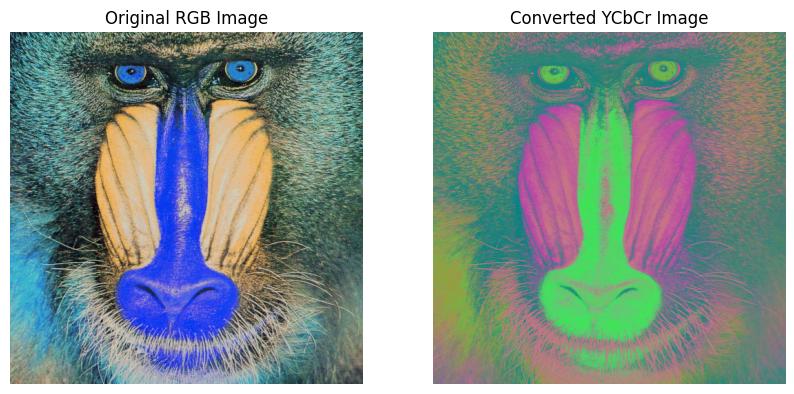

Compression Ratio is 16.0


In [ ]:
#reading file
filename = input("Enter the name of the input file: ")
img = cv2.imread(filename, cv2.IMREAD_COLOR)

#converting RGB to YCBCR
img = rgb_to_ycbcr(img)

width = len(img[0])
height = len(img)

y = [[0]*width]*height

for i in range(height):
  for j in range(width):
    y[i][j] = img[i][j][0]

cr = [[0]*width]*height

for i in range(height):
  for j in range(width):
    cr[i][j] = img[i][j][1]

cb = [[0]*width]*height

for i in range(height):
  for j in range(width):
    cb[i][j] = img[i][j][2]

Original_Bits = len(y) * len(y[0]) * 8 + len(cb) * len(cb[0]) * 8 + len(cr) * len(cr[0]) * 8
Original_Bits /= 16

#centralize
y = Centralize(y)
cr = Centralize(cr)
cb = Centralize(cb)

#subsample
crf = subsample(cr)
cbf = subsample(cb)


yWidth, yLength = ceil(len(y[0]) / 8) * 8, ceil(len(y) / 8) * 8
cWidth, cLength = ceil(len(cbf[0]) / 8) * 8, ceil(len(cbf) / 8) * 8

yPadded = [[0]*yWidth]*yLength
crPadded = [[0]*cWidth]*cLength
cbPadded = [[0]*cWidth]*cLength

for i in range(len(y)):
    for j in range(len(y[0])):
        yPadded[i][j] = y[i][j]

for i in range(len(crf)):
    for j in range(len(crf[0])):
        crPadded[i][j] += crf[i][j]
        cbPadded[i][j] += cbf[i][j]

horY = int(yWidth / 8)
vertY = int(yLength / 8)
horC = int(cWidth / 8)
vertC = int(cLength / 8)

yser = []
crser = []
cbser = []

for i in range(vertY):
    for j in range(horY):
        block = []
        for k in range(8*i, 8*i+8):
          block.append(yPadded[k][8*j:8*j+8])
        mdct = dct(block)
        quant = [[0]*8]*8
        for x in range(8):
          for y in range(8):
            quant[x][y] = round(mdct[x][y] / quant_lum[x][y])
        yser.append(serialize(quant))


for i in range(vertC):
    for j in range(horC):
        block = []
        for k in range(8*i, 8*i+8):
          block.append(crPadded[k][8*j:8*j+8])
        mdct = dct(block)
        for x in range(8):
          for y in range(8):
            quant[x][y] = round(mdct[x][y] / quant_chr[x][y])
        crser.append(serialize(quant))

        block = []
        for k in range(8*i, 8*i+8):
          block.append(cbPadded[k][8*j:8*j+8])
        mdct = dct(block)
        for x in range(8):
          for y in range(8):
            quant[x][y] = round(mdct[x][y] / quant_chr[x][y])
        cbser.append(serialize(quant))

yrun = run_length(yser)
crrun = run_length(crser)
cbrun = run_length(cbser)

yfreq = get_freq_dict(yrun)
crfreq = get_freq_dict(crrun)
cbfreq = get_freq_dict(cbrun)

yhuff = huff(yfreq)
crhuff = huff(crfreq)
cbhuff = huff(cbfreq)

file = open(filename[:-4]+"_compressed.bin", "w")
ytrans = str()
for value in yrun:
    ytrans += yhuff[value]

crtrans = str()
for value in crrun:
    crtrans += crhuff[value]

cbtrans = str()
for value in cbrun:
    cbtrans += cbhuff[value]

if file.writable():
    file.write(ytrans + "\n" + crtrans + "\n" + cbtrans)
file.close()

Compressed_Bits = len(ytrans) + len(crtrans) + len(cbtrans)
print("Compression Ratio is " + str(round(Original_Bits / (Compressed_Bits), 1)))